In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)


from __future__ import division
import types
import uuid
import math
import tensorflow as tf
from scipy.misc import logsumexp
from baselines import deepq
import baselines.common.tf_util as U

In [3]:
%autoreload

In [4]:
np.core.arrayprint._line_width = 160

In [5]:
#%store

In [6]:
data_dir = os.path.join('data', '1.1')

In [7]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
NOOP = 4
EXIT = 5

cdict = {'red':   ((0.0,  0.173, 0.173),
                   (1.0,  0.925, 0.925)),

         'green': ((0.0,  0.067, 0.067),
                   (1.0, 0.384, 0.384)),

         'blue':  ((0.0,  0.027, 0.027),
                   (1.0,  0.196, 0.196))}
plt.register_cmap(name='RustPlanet', data=cdict)
REWARD_COLORS = cm.get_cmap('RustPlanet')
AGENT_COLORS = cm.get_cmap('gray')
MAP_COLORS = {b'B':"#3a0e00",
              b'F':"#933111",
              b'S':"#933111",
              b'U':"#d65b33",
              b'1':"#956F52",
              b'2':"#3C2F34",
              b'3':"#644C42"}

ROVER_PNGS = {LEFT:"utils/rover_left.png",
        RIGHT:"utils/rover_right.png",
        DOWN:"utils/rover_down.png",
        UP:"utils/rover_up.png",
        NOOP:"utils/rover_up.png",
        EXIT:"utils/rover_sample.png"}

# tile_map = [
#         "F3FFUFU2U",
#         "FUFUSUFUF",
#         "FFFUSUFFU",
#         "USUUUUUSU",
#         "FFUSSSUFF",
#         "FSFUSUFSF",
#         "UUUUUUUFU",
#         "UFFU1UFUU",
#         "3UUFUFFU1"
#     ]

# tile_map = [
#         "F22222FF1",
#         "U31122FU1",
#         "UF1112FU1",
#         "UFUU1SFU1",
#         "UFFU1FFU3",
#         "3222UFS1U",
#         "UUU22F1FU",
#         "FSSFS12SF",
#         "FSFF121FF",
#         "S1S2SFFSF",
#         "FUUUFFSFU",
#         "U3UUUFSFU",
#         "FFFUUFUUU"
#     ]

tile_map = [
        "2FFFFFFF1",
#         "FFFFFFFFF",
        "FFFFUFFFF",
        "FSFUUUFSF",
        "FSUU3UUSF",
        "FSFUUUFSF",
        "FFFFUFFFF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]

tile_rewards = {'F':1e-4,
              '1':1e-3,
              '2':1e-3,
              '3':1e-3,
              'S':1e-5,
              'U':0.0}


goal_tile_rewards = {b'F':0.0,
              b'1':1.0,
              b'2':2.0,
              b'3':8.0,
              b'S':0.0,
              b'U':0.0}

tile_reward_modifier = lambda r,x,y,mx,my: r 
#* 0.1 * ((x-(mx/2 + np.random.normal(scale=0.5)))**2 + (y - (mx/2 + np.random.normal(scale=0.5)))**2)

def build_texture_map(tile_map, tile_rewards, tile_reward_modifier):
    texture_map = np.zeros((len(tile_map),len(tile_map[0])))
    for y,row in enumerate(tile_map):
        for x,c in enumerate(row):
            texture_map[y,x] = tile_reward_modifier(tile_rewards[c],x,y,len(tile_map[0]),len(tile_map))
    return texture_map

texture_map = build_texture_map(tile_map, tile_rewards, tile_reward_modifier)


t0 = (0.8,0.1,0.0,0.0)
t1 = (0.0,0.0,0.0,1.0)  #(0.1,0.15,0.5,0.1)

trans_dict = {b'F':t0,
              b'1':t0,
              b'2':t0,
              b'3':t0,
              b'S':t0,
              b'U':t1}

#TODO implement theta_mat in mars_explorer so do not need to hard code, use np.roll
true_tps = np.array([[[0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.0, 1.]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

gamma = 0.98

alpha = 0.0001

T_theta_shape = (5,5,2)

time_penalty = 0.0

beta = 50


In [8]:
# reward_normalizer = (1-gamma)/(np.max(reward_map))
# reward_map *= reward_normalizer
# time_penalty *= reward_normalizer

In [9]:
# temperature = 1/(reward_normalizer)
# print(temperature)

In [10]:
# plt.imshow(reward_map, cmap="Blues")

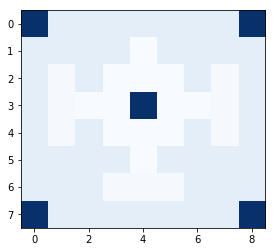

In [11]:
plt.imshow(texture_map, cmap="Blues")

In [12]:
# plt.imshow(reward_map - texture_map, cmap="Blues")

In [13]:
mdp = MarsExplorerEnv(tile_map, goal_tile_rewards, texture_map, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

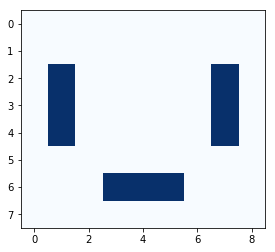

In [14]:
binary_map = np.ones(mdp.tile_map.shape)
binary_map[np.where(mdp.tile_map == b'S')] = 255.0
plt.imshow(binary_map, cmap="Blues")

In [15]:
def plot_mars(mdp, pi, term = 40, title=None, counts = None, Qs = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    s = mdp._reset()
    t, r = 0, 0
    while s != mdp.end_state and t < term:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        a = pi[s] if type(pi) == np.ndarray else pi(s)
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}      r: {}'.format(t,round(r,4)), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        if Qs is not None:
            print(Qs[s])
            print(a)
            print(softmax(Qs[s]))
        print(mdp.s_to_grid(s))
        s, rt, _, d = mdp._step(a)
        print(mdp.s_to_grid(s))
        t += 1
        r += rt
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_mars_history(mdp, hist, title=None, counts = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    t = 0
    for s,a,sprime in [h[0] for h in hist]:
        if sprime == mdp.end_state:
            continue
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}'.format(t), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        t += 1
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_values(mdp, Qs, s=None, title=None):
    if Qs.size != mdp.nrow * mdp.ncol:
        Qs = Qs[: mdp.nrow * mdp.ncol]
    V = np.max(Qs, axis=1).reshape((mdp.nrow,mdp.ncol))
    pi = np.argmax(Qs, axis=1)
    plt.figure(figsize=(8,8))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1), 4:(-1,-1), 5:(1,1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.2, head_length=0.1) 
            plt.text(x, y, str(mdp.tile_map[y,x].item().decode()),
                     color='c', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
#     plt.grid(color='b', lw=2, ls='-')
    return

# Soft-Q Learning

In [16]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

In [17]:
def tabsoftq_iter(R, T, maxiter=10000, verbose=False, Q_init=None, learning_rate=0.5, ftol=1e-32):
    Q = np.zeros((nS, nA)) if Q_init is None else copy(Q_init)
    prevQ = copy(Q)
    if verbose:
        diffs = []
        meanVs = []
    for iter_idx in range(maxiter):
#         V = logsumexp(prevQ, axis=1)
        V = alpha * logsumexp(prevQ / alpha, axis=1)
        V_broad = V.reshape((1, 1, nS))
        Q = R + gamma * np.sum(T * V_broad, axis=2)
        Q = (1 - learning_rate) * prevQ + learning_rate * Q
        diff = np.mean((Q - prevQ)**2)/(np.std(Q)**2)
        if verbose:
            diffs.append(diff)
            meanVs.append(np.mean(V)) 
        if diff < ftol:
            break
        prevQ = copy(Q)
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Value of All Tiles')
        plt.title('Soft Q Iteration')
        plt.plot(meanVs)
        plt.show()
    return Q

In [18]:
def tabsoftq_learn_Qs(mdp):
    R = mdp.get_reward_matrix()
    T = mdp.get_transition_matrix()
    Qs = tabsoftq_iter(R, T)
    return Qs

def tabsoftq_gen_pol(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return lambda s: np.random.choice(np.asarray(range(len(Qs[s]))),p=softQs[s])

def tabsoftq_gen_pol_probs(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return softQs


In [19]:
def generate_demonstrations(mdp, pol, n, term):
    hists = []
    for i in range(n):
        s, d, t = mdp._reset(), False, 0
        hist = []
        while not d and t < term:
            a = pol[s] if type(pol) == np.ndarray else pol(s)
            sprime, rt, _, ob_dict = mdp._step(a)
            hist += [((s,a,sprime),ob_dict['adt'])]
            t += 1
            s = sprime
        hists += [hist]
    return hists

In [20]:
def vectorize_rollouts(rollouts):
    sas_obs = []
    adt_obs = []
    task_idxes = []
    for rollout in rollouts:
        more_sas, more_adt = list(zip(*rollout))
        sas_obs.extend(more_sas)
        adt_obs.extend(more_adt)
    return np.array(sas_obs), np.array(adt_obs)

Sanity check (env and softq)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  if __name__ == '__main__':
/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


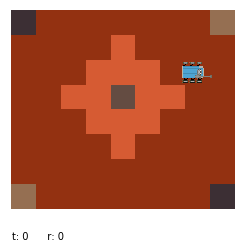

[1.61230445 1.73188639 1.81642517 1.80063135 1.78010666 0.00878962]
2
[0.16822016 0.18958843 0.20631298 0.2030801  0.19895443 0.0338439 ]
(7, 2)
(8, 2)


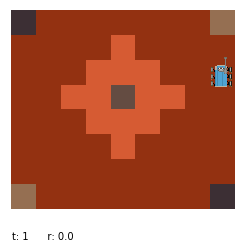

[1.78923418 1.78556367 1.84819363 1.86186963 1.82473224 0.00887962]
3
[0.18736694 0.18668047 0.19874615 0.20148287 0.19413756 0.03158601]
(8, 2)
(8, 1)


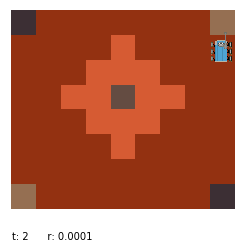

[1.83595051 1.83348686 1.9029791  1.91119944 1.87307546 0.00887962]
3
[0.18713539 0.18667492 0.20010874 0.20176049 0.19421335 0.03010711]
(8, 1)
(8, 0)


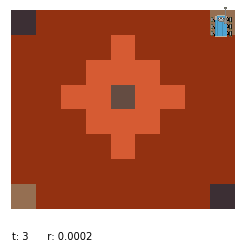

[1.88364171 1.88363699 1.96092317 1.96092385 1.92277297 1.00977962]
3
[0.17800145 0.17800061 0.19230317 0.1923033  0.18510495 0.07428653]
(8, 0)
(0, 0)


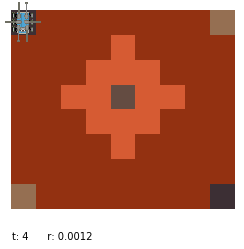

[1.92162556 1.91244577 1.91244631 1.92162611 1.97058403 2.00977962]
5
[0.1632904  0.16179829 0.16179838 0.16329049 0.17148378 0.17833865]
(0, 0)
(900, 900)


In [21]:
Q = tabsoftq_learn_Qs(mdp)
plot_mars(mdp,tabsoftq_gen_pol(Q, beta=100),Qs=Q)


# NN IDL

In [22]:
train_demo_example_idxes = None
val_demo_example_idxes = None

iterations = 100000
learning_rate = 1e-1
batch_size = 512
sq_td_penalty = 1e0
inf_td_penalty = 0
trans_err_penalty = 1e0
lse_temp = 1
lse_stab = 0


q_n_layers = 2
q_layer_size = 64
q_activation = tf.nn.tanh
q_output_activation = None

invdyn_n_layers = 1
invdyn_layer_size = 64
invdyn_activation = tf.nn.relu
invdyn_output_activation = None


constraint_sampling_freq = 100000
constraint_batch_size = batch_size
n_constraint_rollouts_per_env = 100

val_update_freq = 1

In [23]:
n_obs_feats = 2
n_act_dim = 6
featurize_states = lambda states: np.array([mdp.s_to_grid(state) for state in states])
featurize_acts = lambda a: a
n_dirs = 6
n_tile_dim = 3

In [24]:
def build_mlp(
    input_placeholder,
    output_size,
    scope,
    n_layers=1,
    size=256,
    activation=tf.nn.relu,
    output_activation=None,
    reuse=False
      ):
    out = tf.cast(input_placeholder, tf.float32)
    with tf.variable_scope(scope, reuse=reuse):
        for _ in range(n_layers):
            out = tf.layers.dense(out, size, activation=activation)
        out = tf.layers.dense(out, output_size, activation=output_activation)
    return out

In [25]:
def nn_vectorize_rollouts(sas_obs, adt_obs):
    states, acts, next_states = zip(*sas_obs)
    _, dirs, tiles = zip(*adt_obs)
    states_feats = featurize_states(states)
    states = np.expand_dims(np.array(states), axis=1)
    actions = np.expand_dims(np.array(acts), axis=1)
    next_states_feats = featurize_states(next_states)
    next_states = np.expand_dims(np.array(next_states), axis=1)
    dirs = np.expand_dims(np.array(dirs), axis=1)
    tiles = np.expand_dims(np.array(tiles), axis=1)
    return (states, states_feats, actions, next_states, next_states_feats, dirs, tiles)

def get_rollout_indexes(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    random.shuffle(demo_example_idxes)
    n_train_demo_examples = int(0.9 * len(demo_example_idxes))
    train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
    val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
    return (train_demo_example_idxes, val_demo_example_idxes)

def sample_batch(rollouts, indexes, size=None):
    idxes = random.sample(indexes, size) if size is not None else indexes
    demo_batch = [comp[idxes] for comp in rollouts]
    return demo_batch

def generate_constraints(mdp):
    s = np.arange(mdp.nS)
    a = np.arange(mdp.nA) 
    sa = np.transpose([np.tile(s, len(a)), np.repeat(a, len(s))])
    states, acts = sa[:,0], sa[:,1]
    feat_states = featurize_states(states)
    tiles = np.expand_dims(np.array([mdp.get_tile_type(s) for s in states]), axis=1)
    acts_array = np.expand_dims(acts,axis=1)
    rewards = np.array([mdp.get_reward(states[i], acts[i]) for i in range(len(states))])
    sprimes = mdp.get_possible_sprimes(feat_states)
    end_states = np.where(states==mdp.end_state)[0]

    return feat_states, acts_array, rewards, sprimes, tiles, end_states

In [26]:
# im_scope =  str(uuid.uuid4())
# q_scope = str(uuid.uuid4())
# invsas_scope = str(uuid.uuid4())
# invadt_scope = str(uuid.uuid4())

# with open(os.path.join(data_dir, 'im_scope.pkl'), 'wb') as f:
#     pkl.dump(im_scope, f)

# with open(os.path.join(data_dir, 'q_scope.pkl'), 'wb') as f:
#     pkl.dump(q_scope, f)

# with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'wb') as f:
#     pkl.dump(invsas_scope, f)
    
# with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'wb') as f:
#     pkl.dump(invadt_scope, f)

In [27]:
with open(os.path.join(data_dir, 'im_scope.pkl'), 'rb') as f:
    im_scope = pkl.load(f)

with open(os.path.join(data_dir, 'q_scope.pkl'), 'rb') as f:
    q_scope = pkl.load(f)

with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'rb') as f:
    invsas_scope = pkl.load(f)
    
with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'rb') as f:
    invadt_scope = pkl.load(f)

In [28]:
sess = tf.Session()

In [29]:
demo_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dot")
demo_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="dtt")
demo_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="dat")
demo_next_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dnot")
demo_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dotf")
demo_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dnotf")
demo_dir_t_ph = tf.placeholder(tf.int32, [None, 1], name="ddt")
demo_batch_size_ph = tf.placeholder(tf.int32, name="dbs")

constraint_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="cot")
constraint_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="ctt")
constraint_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="cotf")
constraint_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="cat")
constraint_rew_t_ph = tf.placeholder(tf.float32, [None], name="crt")
constraint_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_dirs, n_obs_feats], name="cnotf")
# constraint_end_states_ph = tf.placeholder(tf.int32, [None], name="cdt")
constraint_batch_size_ph = tf.placeholder(tf.int32, name="cbs")

In [30]:
demo_q_t = build_mlp(demo_obs_t_feats_ph,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation)

# demo_v_t = tf.reduce_logsumexp(
#   tf.stack([build_mlp(
#     extract_task(demo_obs_t_ph, train_task_idx),
#     n_act_dim, q_scope+'-'+str(train_task_idx), 
#     n_layers=q_n_layers, size=q_layer_size,
#     activation=q_activation, output_activation=q_output_activation,
#     reuse=True
#   ) for train_task_idx in range(n_train_tasks)], axis=0),
#   axis=2)

In [31]:
# demo_v_t = tf.reduce_logsumexp((demo_q_t-lse_stab) * lse_temp, axis=1) / lse_temp + lse_stab

demo_v_t = tf.reduce_logsumexp(demo_q_t * beta, axis=1)

action_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_act_t_ph], axis=1)

act_log_likelihoods = tf.gather_nd(demo_q_t, action_indexes) * beta - demo_v_t

neg_avg_act_log_likelihood = -tf.reduce_mean(act_log_likelihoods)

In [32]:
demo_act_one_hot = tf.one_hot(tf.squeeze(demo_act_t_ph,axis=[1]), n_act_dim, dtype=tf.int32)
demo_tile_one_hot = tf.one_hot(tf.squeeze(demo_tile_t_ph, axis=[1]), n_tile_dim, dtype=tf.int32)

sas_pred_obs = build_mlp(
  tf.concat((demo_obs_t_feats_ph, demo_act_one_hot), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

adt_pred_dir = build_mlp(
  tf.concat((demo_act_one_hot, demo_tile_one_hot), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

dir_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_dir_t_ph], axis=1)

adt_log_likelihoods = tf.gather_nd(adt_pred_dir, dir_indexes) - tf.reduce_logsumexp(adt_pred_dir, axis=1)

neg_avg_adt_log_likelihood = -tf.reduce_mean(adt_log_likelihoods)

sas_log_likelihoods = tf.gather_nd(sas_pred_obs, dir_indexes) - tf.reduce_logsumexp(sas_pred_obs, axis=1)

neg_avg_sas_log_likelihood = -tf.reduce_mean(sas_log_likelihoods)

In [33]:
ca_indexes = tf.concat([tf.expand_dims(tf.range(constraint_batch_size_ph), 1), constraint_act_t_ph], axis=1)

constraint_q_ts = build_mlp(constraint_obs_t_feats_ph,
        n_act_dim, q_scope, 
        n_layers=q_n_layers, size=q_layer_size,
        activation=q_activation, output_activation=q_output_activation,
        reuse=True)

constraint_q_t = tf.gather_nd(constraint_q_ts, ca_indexes)


constraint_act_one_hot = tf.one_hot(tf.squeeze(constraint_act_t_ph, axis=[1]), n_act_dim, dtype=tf.int32)
constraint_tile_one_hot = tf.one_hot(tf.squeeze(constraint_tile_t_ph, axis=[1]), n_tile_dim, dtype=tf.int32)

# Predicted constraint next state given inv dyns
constraint_sas_pred_obs = build_mlp(
  tf.concat((constraint_obs_t_feats_ph, constraint_act_one_hot), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

constraint_adt_pred_dir = build_mlp(
  tf.concat((constraint_act_one_hot, constraint_tile_one_hot), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

In [34]:
constraint_sprimes_reshaped = tf.reshape(constraint_next_obs_t_feats_ph, (constraint_batch_size_ph * n_dirs, n_obs_feats))

In [35]:
cqtp1_misshaped = build_mlp(constraint_sprimes_reshaped,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation,
    reuse=True)

constraint_q_tp1 = tf.reshape(cqtp1_misshaped, (constraint_batch_size_ph, n_dirs, n_act_dim))

constraint_v_tp1 = tf.reduce_logsumexp((constraint_q_tp1 - lse_stab) * lse_temp, axis=2) / lse_temp + lse_stab

In [36]:
constraint_sas_pred_probs = tf.nn.softmax(constraint_sas_pred_obs, axis=1)
constraint_adt_pred_probs = tf.nn.softmax(constraint_adt_pred_dir, axis=1)
sas_V = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_sas_pred_probs))
adt_V = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_adt_pred_probs))
sas_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(sas_V, axis=1)
adt_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V, axis=1)

In [37]:
# mesh = tf.meshgrid(tf.range(indices.shape[1]), tf.range(indices.shape[0]))[1]
# full_indices = tf.reshape(tf.stack([mesh, indices], axis=2), [-1,2])
# dense = tf.sparse_to_dense(full_indices, tf.constant(constraint_batch_size_ph), tf.ones(tf.shape(full_indices)[0]))


# true_sas_target_t = tf.multiply(sas_target_t, tf.cast(mask1, sas_target_t.dtype))
# true_adt_target_t = tf.multiply(adt_target_t, tf.cast(mask2, adt_target_t.dtype))


In [38]:
sas_td_err = tf.reduce_mean((constraint_q_t - sas_target_t)**2)
adt_td_err = tf.reduce_mean((constraint_q_t - adt_target_t)**2)

sas_inf_td_err = tf.reduce_max(tf.abs(constraint_q_t - sas_target_t))
adt_inf_td_err = tf.reduce_max(tf.abs(constraint_q_t - adt_target_t))

In [39]:
sas_loss = neg_avg_act_log_likelihood + trans_err_penalty * neg_avg_sas_log_likelihood + sq_td_penalty * sas_td_err # + inf_td_penalty * sas_inf_td_err
adt_loss = neg_avg_act_log_likelihood + trans_err_penalty * neg_avg_adt_log_likelihood + sq_td_penalty * adt_td_err #+ inf_td_penalty * adt_inf_td_err

In [40]:
sas_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(sas_loss)
adt_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(adt_loss)
adt_trans_only_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(neg_avg_adt_log_likelihood)

In [41]:
def compute_batch_loss(demo_batch, constraints, step=False, adt=False, trans=False, t=None):
    feed_dict = {
        demo_obs_t_feats_ph: demo_batch[1],
        demo_act_t_ph: demo_batch[2],
        demo_next_obs_t_feats_ph: demo_batch[4],
        demo_dir_t_ph: demo_batch[5],
        demo_tile_t_ph: demo_batch[6],
        demo_batch_size_ph: demo_batch[2].shape[0],
        constraint_obs_t_feats_ph: constraints[0],
        constraint_act_t_ph: constraints[1],
        constraint_rew_t_ph: constraints[2],
        constraint_next_obs_t_feats_ph: constraints[3],
        constraint_tile_t_ph: constraints[4],
#         constraint_end_states_t_ph: constraints[5],
        constraint_batch_size_ph: constraints[0].shape[0]
    }
      
    if trans: 
        [trans_likelihood_eval] = sess.run([neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_trans_only_update_op
        if step:
            sess.run(update_op, feed_dict=feed_dict)
        return {'loss':trans_likelihood_eval}
    
    if adt:
        [loss_eval, act_likelihood_eval, td_err_eval, inf_td_eval, trans_likelihood_eval] = sess.run(  #, cqts_end , constraint_q_ts[437]
            [adt_loss, neg_avg_act_log_likelihood, adt_td_err, adt_inf_td_err, neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_update_op
#         print(cqts_end)
        
    else:
        [loss_eval, act_likelihood_eval, td_err_eval, inf_td_eval, trans_likelihood_eval] = sess.run(
            [sas_loss, neg_avg_act_log_likelihood, sas_td_err, sas_inf_td_err, neg_avg_sas_log_likelihood], feed_dict=feed_dict)
        update_op = sas_update_op
 
    if step:
        sess.run(update_op, feed_dict=feed_dict)

    d = {
        'loss': loss_eval,
        'nall': act_likelihood_eval,
        'tde': td_err_eval,
        'itde': inf_td_eval,
        'ntll': trans_likelihood_eval
        }

    return d

# IDL & SERD Experiments

In [42]:
batch_size = 200
n_demos = 200
demo_time_steps = 40

In [43]:
def clean_demos(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays, stay_count = set([]), 0
    for i,sas in enumerate(sas_obs):
        sas = tuple(sas)
        if sas[0] == mdp.end_state:
            stay_count += 1
            if stay_count > 2:
                demo_example_idxes.remove(i)
        else:
            stay_count = 0
    return demo_example_idxes

# def sample_batch(size, ids, sas_obs, adt_obs):
#     idxes = random.sample(ids, size)
#     return sas_obs[idxes], adt_obs[idxes]

In [44]:
def T_estimate(adt_obs):
    stability = 1e-5
    T_thetas = np.zeros(T_theta_shape)
    T_counts = np.zeros(T_theta_shape) + stability
    for a,d,t in adt_obs:
        T_counts[a,d,t] += 1
    for a in range(T_theta_shape[0]):
        for t in range(T_theta_shape[2]):
            z = np.sum(T_counts[a,:,t])
            for d in range(T_theta_shape[1]):
                if z == T_counts.shape[1] * stability:
                    T_thetas[a,d,t] = 0
                else:
                    T_thetas[a,d,t] = np.log(T_counts[a,d,t]) - np.log(z)
    return T_thetas

def test_T_likelihood(Tps, sas_obs, adt_obs):
    T = mdp.adt_trans_to_sas_trans(Tps)
    R = mdp.rewards
    Q = tabsoftq_iter(R, T, Q_init=None, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    pl = eval_pol_likelihood(Q, sas_obs, verbose=True)
    tl = eval_trans_likelihood(Tps, adt_obs, verbose=True)
    print([s for s in range(nS) if mdp.get_tile_type(s)==1])
    print(Q[[s for s in range(nS) if mdp.get_tile_type(s)==1]])
    print(pl, tl)
    return pl + tl

def true_trans_loss(tps):
    tps = mdp.adt_trans_to_sas_trans(tps)
    true_tps = mdp.get_transition_matrix()
    return np.linalg.norm(true_tps-tps)/mdp.nA

In [45]:
beta = 50
exQs = tabsoftq_learn_Qs(mdp)
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs, beta=beta), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  if __name__ == '__main__':


In [46]:
# Ensure bad areas have not been visited in exes
demos = []
while len(demos) < n_demos:
    new_demo = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs, beta=beta), 1, demo_time_steps)[0]
    more_sas, more_adt = list(zip(*new_demo))
    if 1 not in set([adt[2] for adt in more_adt]):
        demos += [new_demo]
        
sas_obs, adt_obs = vectorize_rollouts(demos)

# IDL NN

In [47]:
n_training_iters = 200000

In [48]:
good_indexes = clean_demos(sas_obs)
sas_obs, adt_obs = sas_obs[good_indexes], adt_obs[good_indexes]
constraints = generate_constraints(mdp)
nn_rollouts = nn_vectorize_rollouts(sas_obs, adt_obs)
train_idxes, val_idxes = get_rollout_indexes(sas_obs)
val_demo_batch = sample_batch(nn_rollouts, val_idxes)

In [49]:
tf.global_variables_initializer().run(session=sess)

In [50]:
full_train_logs = {
  'loss_evals': [],
  'ntll_evals': [],
  'nall_evals': [],
  'tde_evals': [],
  'itde_evals': [],
  'val_loss_evals': [],
  'val_ntll_evals': [],
  'val_nall_evals': [],
  'val_tde_evals': [],
  'val_itde_evals': []
}

0 200000 258.498749 1.724134 212.113373 44.661228 14.045071
1000 200000 5.078271 0.422071 2.386527 2.269673 7.894684
2000 200000 4.293976 0.418464 1.694139 2.181373 7.624966
3000 200000 4.544846 0.420918 1.987224 2.136704 7.503553
4000 200000 4.224697 0.423140 1.678236 2.123322 7.336929
5000 200000 3.730480 0.423372 1.210572 2.096536 7.335242
6000 200000 3.654417 0.422730 1.154231 2.077456 7.307828
7000 200000 3.825285 0.418706 1.337720 2.068858 7.129084
8000 200000 3.711954 0.422312 1.228437 2.061205 7.057556
9000 200000 3.629011 0.418035 1.160199 2.050777 6.994033


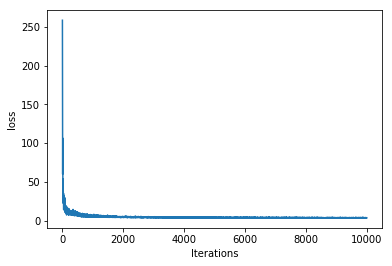

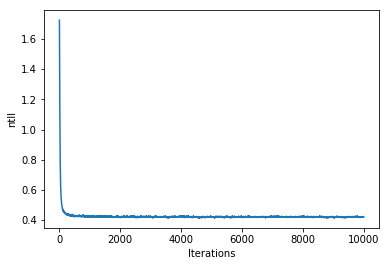

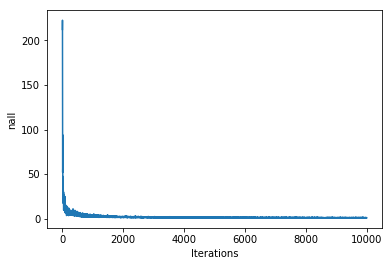

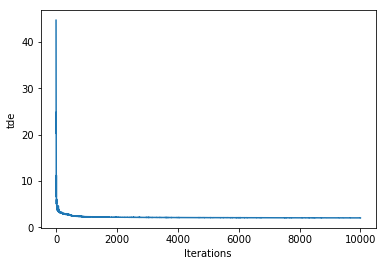

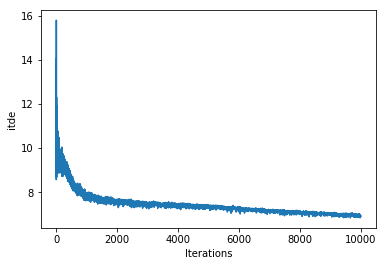

10000 200000 3.645440 0.421940 1.181071 2.042428 6.930212
11000 200000 3.644837 0.414841 1.194522 2.035475 6.834969
12000 200000 3.511644 0.417373 1.067731 2.026540 6.798158
13000 200000 3.609034 0.420797 1.168922 2.019316 6.762312
14000 200000 3.467528 0.421801 1.032747 2.012980 6.692091
15000 200000 3.465313 0.420445 1.034519 2.010349 6.627141
16000 200000 3.503215 0.417449 1.080332 2.005434 6.555892
17000 200000 3.575411 0.421131 1.156788 1.997492 6.521780
18000 200000 3.598457 0.419687 1.182480 1.996290 6.448339
19000 200000 3.469216 0.421710 1.058816 1.988690 6.417847


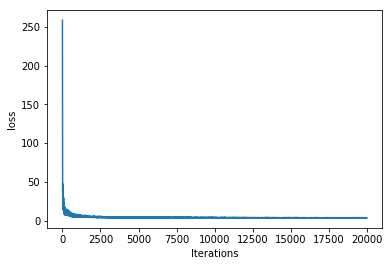

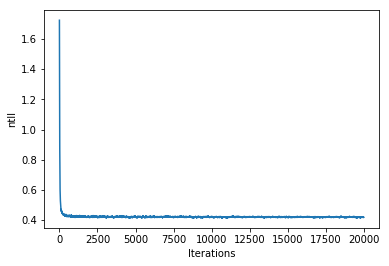

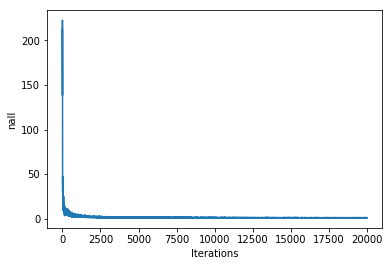

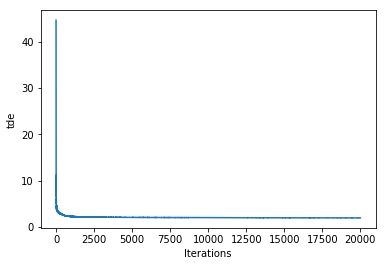

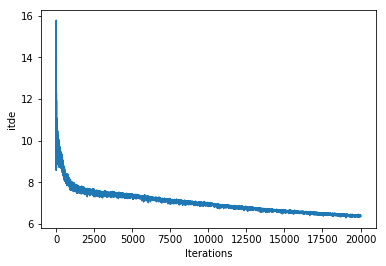

20000 200000 3.442827 0.418641 1.043930 1.980256 6.400460
21000 200000 3.501959 0.419471 1.104067 1.978421 6.380766
22000 200000 3.457911 0.421973 1.059142 1.976796 6.302909
23000 200000 3.622097 0.417923 1.235940 1.968234 6.294566
24000 200000 3.561687 0.417347 1.177473 1.966867 6.230034
25000 200000 3.471681 0.421789 1.082845 1.967047 6.181275
26000 200000 3.377173 0.417727 1.001732 1.957714 6.205247
27000 200000 3.425394 0.420496 1.049050 1.955848 6.170604
28000 200000 3.505955 0.420349 1.138017 1.947588 6.193053
29000 200000 3.474906 0.418632 1.106787 1.949487 6.112955


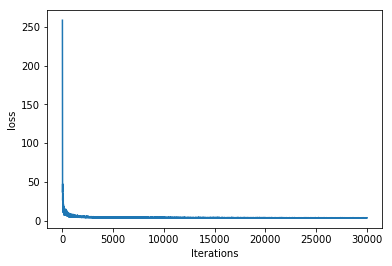

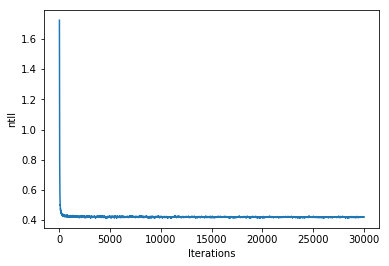

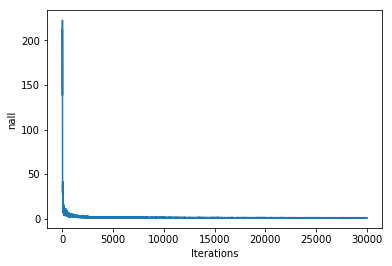

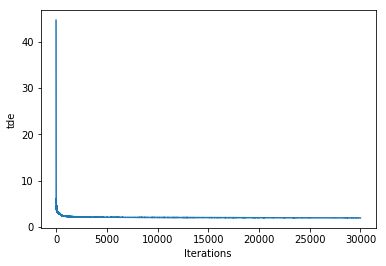

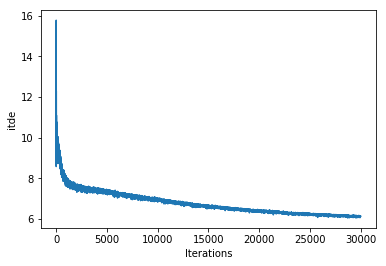

30000 200000 3.394224 0.421101 1.029019 1.944104 6.119348
31000 200000 3.421122 0.420889 1.055496 1.944737 6.084432
32000 200000 3.503083 0.420582 1.144029 1.938472 6.065398
33000 200000 3.424546 0.419768 1.068070 1.936708 6.039122
34000 200000 3.391081 0.421050 1.038046 1.931985 6.042664
35000 200000 3.565350 0.418713 1.214337 1.932300 6.022059
36000 200000 3.424312 0.418446 1.070847 1.935018 5.959560
37000 200000 3.401689 0.419761 1.058351 1.923576 6.022321
38000 200000 3.548076 0.420559 1.206985 1.920533 5.996637
39000 200000 3.479359 0.420293 1.142644 1.916422 5.984761


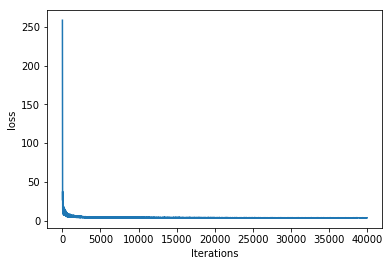

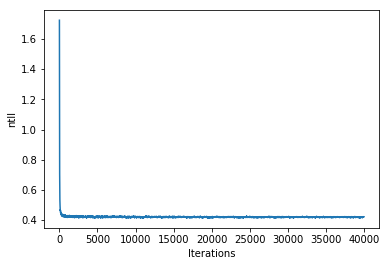

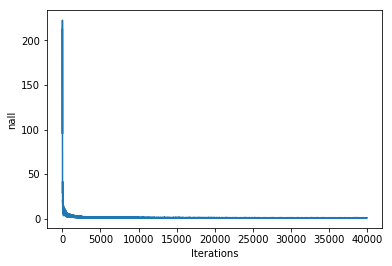

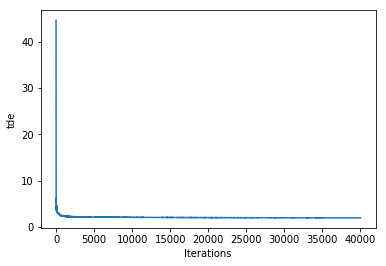

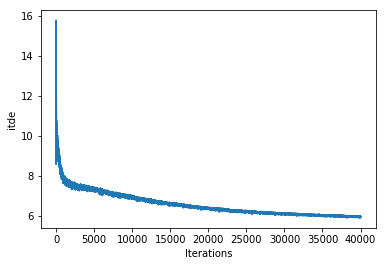

40000 200000 3.520753 0.420218 1.178920 1.921615 5.945581
41000 200000 3.449828 0.418734 1.115964 1.915131 5.939874
42000 200000 3.431381 0.416613 1.103023 1.911745 5.938474
43000 200000 3.507166 0.418928 1.175565 1.912673 5.893283
44000 200000 3.392797 0.420007 1.064897 1.907893 5.903750
45000 200000 3.365260 0.418215 1.046565 1.900481 5.887746
46000 200000 3.374144 0.419353 1.056099 1.898692 5.877161
47000 200000 3.381392 0.418580 1.064960 1.897852 5.864313
48000 200000 3.390802 0.417082 1.080806 1.892914 5.831391
49000 200000 3.349597 0.421143 1.039956 1.888498 5.841083


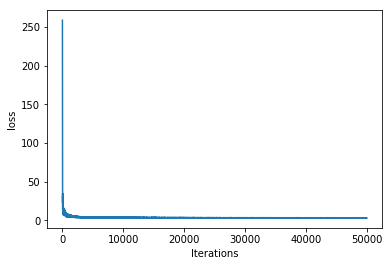

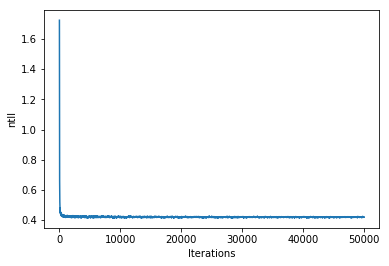

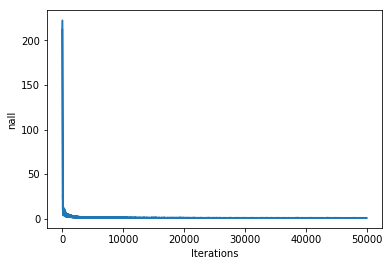

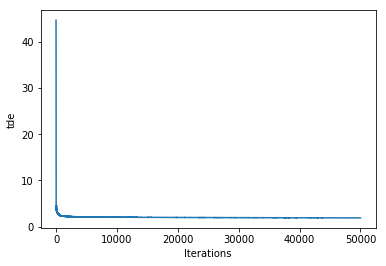

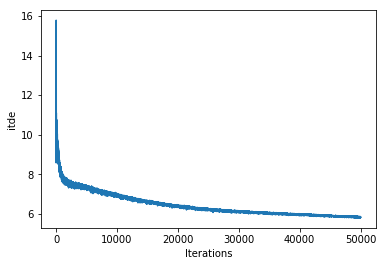

50000 200000 3.388336 0.419589 1.078979 1.889768 5.820577
51000 200000 3.367622 0.421530 1.056020 1.890072 5.811418
52000 200000 3.381267 0.419000 1.079934 1.882333 5.787672
53000 200000 3.337711 0.420393 1.038577 1.878742 5.779696
54000 200000 3.360949 0.417891 1.068714 1.874344 5.782624
55000 200000 3.311590 0.418041 1.020781 1.872769 5.777637
56000 200000 3.346387 0.418007 1.057402 1.870979 5.749924
57000 200000 3.429612 0.419396 1.138642 1.871573 5.746363
58000 200000 3.337919 0.418662 1.053870 1.865386 5.748806
59000 200000 3.385021 0.418869 1.104751 1.861400 5.748615


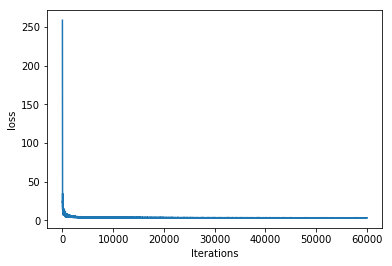

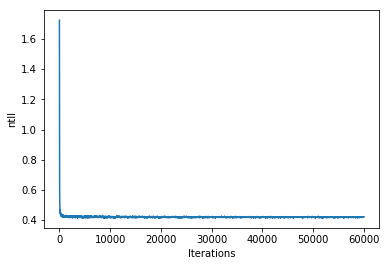

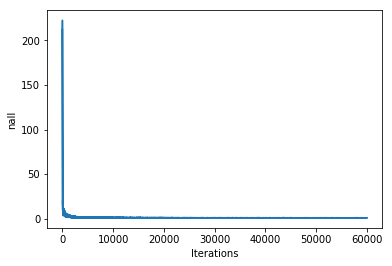

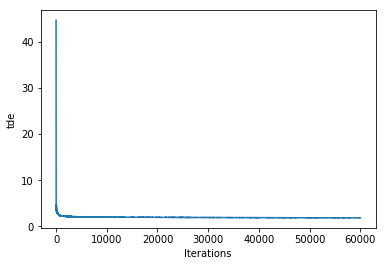

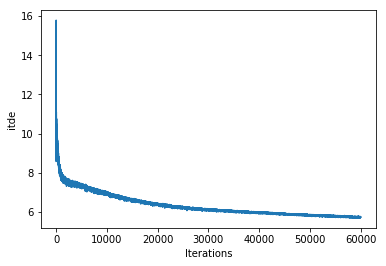

60000 200000 3.568562 0.420408 1.291563 1.856591 5.743508
61000 200000 3.344560 0.416538 1.071924 1.856097 5.722666
62000 200000 3.346897 0.418645 1.070067 1.858185 5.697891
63000 200000 3.352966 0.419863 1.081645 1.851458 5.699330
64000 200000 3.321638 0.419565 1.054971 1.847101 5.708555
65000 200000 3.337811 0.420292 1.073765 1.843755 5.705214
66000 200000 3.299284 0.419343 1.039324 1.840617 5.701331
67000 200000 3.363114 0.419526 1.107035 1.836554 5.731335
68000 200000 3.258333 0.418811 1.003802 1.835720 5.713722
69000 200000 3.289285 0.420677 1.039438 1.829171 5.742977


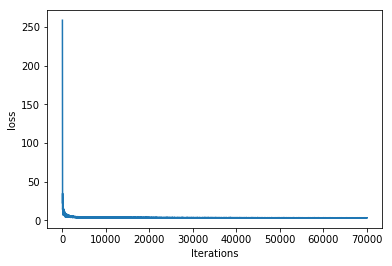

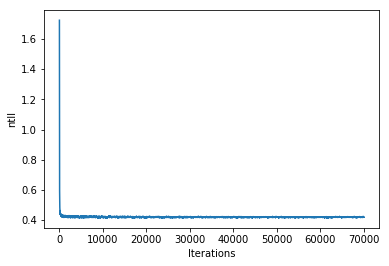

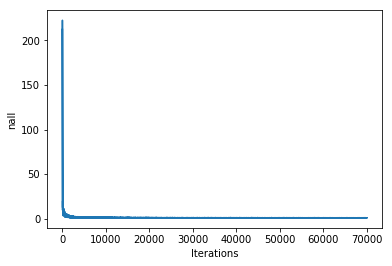

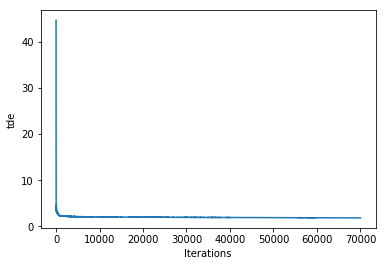

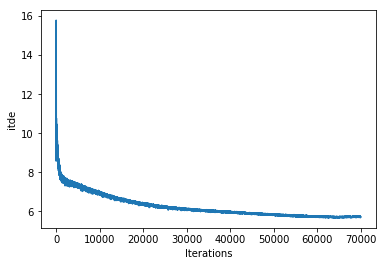

70000 200000 3.348313 0.418906 1.099741 1.829665 5.709346
71000 200000 3.315067 0.419686 1.068408 1.826973 5.709896
72000 200000 3.328714 0.419498 1.085294 1.823922 5.692272
73000 200000 3.259570 0.417096 1.020087 1.822387 5.674230
74000 200000 3.245625 0.419333 1.009794 1.816498 5.679345
75000 200000 3.289086 0.419570 1.055775 1.813740 5.673844
76000 200000 3.312154 0.421541 1.076040 1.814573 5.634477
77000 200000 3.330322 0.418267 1.100984 1.811071 5.647083
78000 200000 3.271638 0.421414 1.042922 1.807302 5.627905
79000 200000 3.258908 0.418055 1.036471 1.804382 5.613807


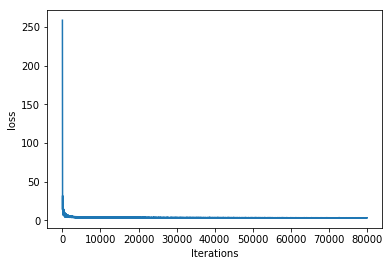

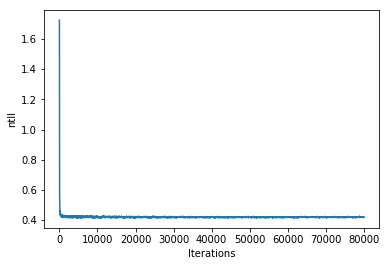

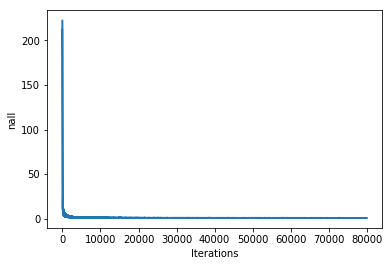

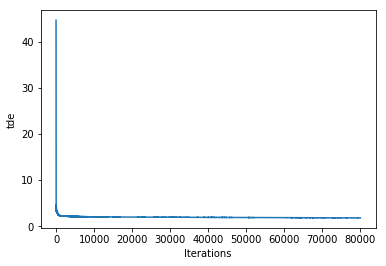

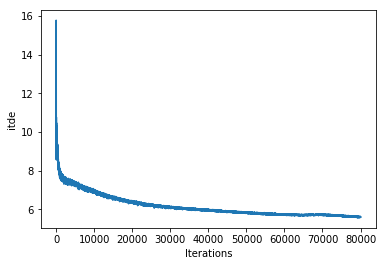

80000 200000 3.254634 0.419866 1.031161 1.803607 5.610161
81000 200000 3.267121 0.417279 1.050372 1.799470 5.584276
82000 200000 3.233871 0.420161 1.012456 1.801254 5.577038
83000 200000 3.236511 0.419683 1.021152 1.795677 5.555396
84000 200000 3.205901 0.418389 0.993596 1.793917 5.533989
85000 200000 3.275536 0.417568 1.068505 1.789463 5.539176
86000 200000 3.235734 0.419921 1.027946 1.787867 5.523108
87000 200000 3.296272 0.420567 1.090320 1.785385 5.513045
88000 200000 3.267994 0.418332 1.066087 1.783575 5.500988
89000 200000 3.285344 0.417923 1.087555 1.779865 5.494357


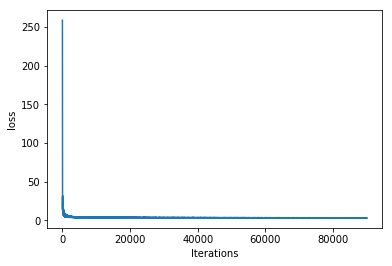

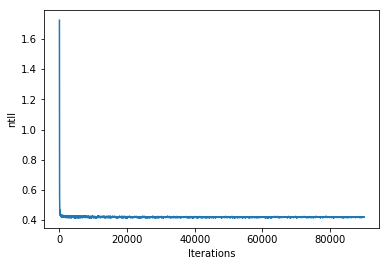

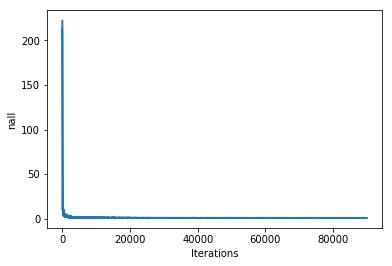

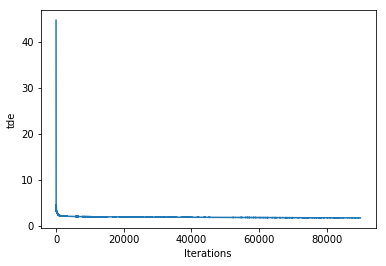

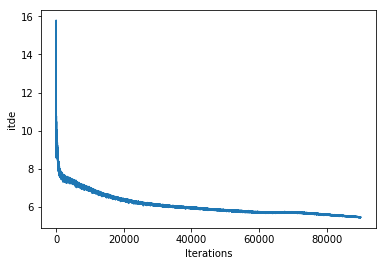

90000 200000 3.246481 0.419591 1.045364 1.781526 5.454693
91000 200000 3.235268 0.418178 1.041790 1.775299 5.469959
92000 200000 3.229477 0.418806 1.036855 1.773816 5.458227
93000 200000 3.177123 0.419486 0.986099 1.771537 5.446607
94000 200000 3.206700 0.420302 1.017107 1.769291 5.430373
95000 200000 3.255244 0.419388 1.066650 1.769206 5.401032
96000 200000 3.206630 0.420412 1.020522 1.765697 5.393585
97000 200000 3.247832 0.418361 1.066673 1.762798 5.384637
98000 200000 3.201207 0.419563 1.019239 1.762405 5.369883
99000 200000 3.234170 0.420053 1.051794 1.762323 5.353485


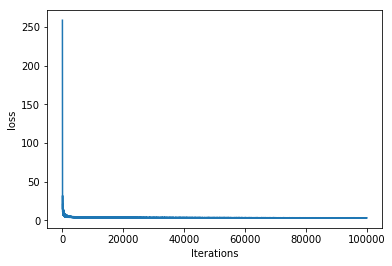

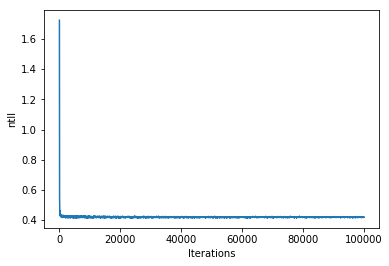

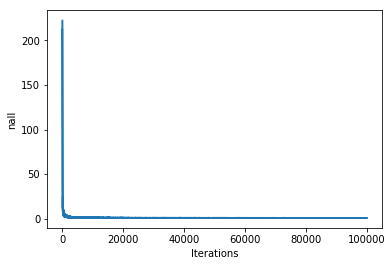

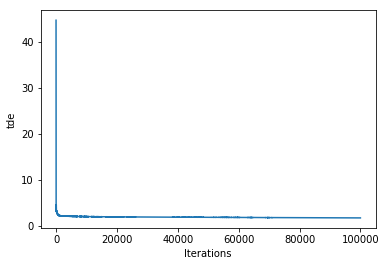

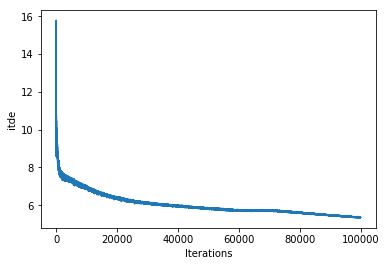

100000 200000 3.263912 0.417649 1.090828 1.755435 5.361322
101000 200000 3.184828 0.419727 1.011135 1.753965 5.341188
102000 200000 3.200440 0.420617 1.027326 1.752497 5.340353
103000 200000 3.186373 0.421076 1.014095 1.751202 5.314423
104000 200000 3.211679 0.417857 1.045676 1.748145 5.305588
105000 200000 3.186043 0.416974 1.022367 1.746702 5.304472
106000 200000 3.220118 0.420725 1.056277 1.743116 5.285605
107000 200000 3.272379 0.420383 1.110391 1.741605 5.279900
108000 200000 3.192004 0.421212 1.030412 1.740380 5.275638
109000 200000 3.157296 0.420230 0.997942 1.739124 5.243766


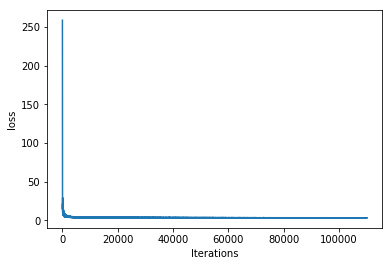

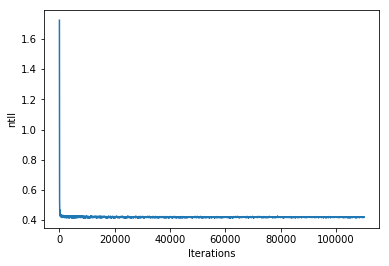

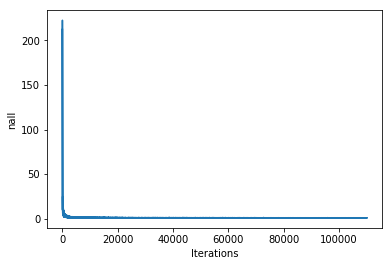

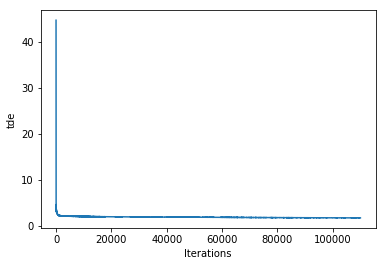

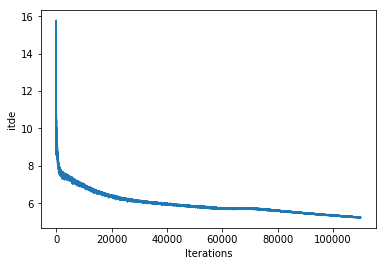

110000 200000 3.245235 0.419886 1.091094 1.734255 5.253813
111000 200000 3.169585 0.421051 1.013530 1.735004 5.232580
112000 200000 3.174559 0.418332 1.024476 1.731751 5.232827
113000 200000 3.174992 0.417833 1.024654 1.732505 5.194417
114000 200000 3.174984 0.419079 1.027252 1.728652 5.189435
115000 200000 3.204386 0.419022 1.058717 1.726647 5.199727
116000 200000 3.172582 0.418828 1.027273 1.726480 5.187199
117000 200000 3.148857 0.421386 1.004829 1.722642 5.160270
118000 200000 3.159016 0.418816 1.020209 1.719991 5.171084
119000 200000 3.158684 0.420037 1.017756 1.720892 5.131584


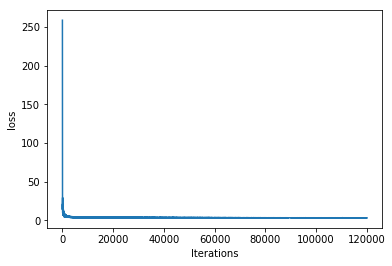

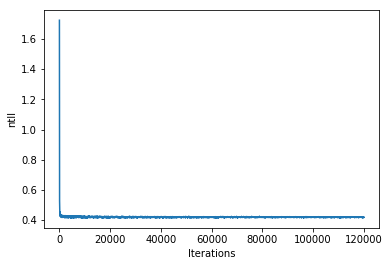

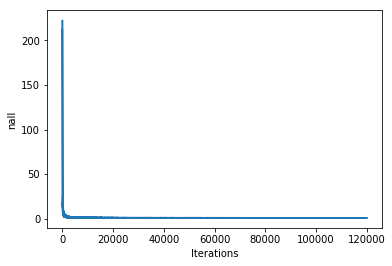

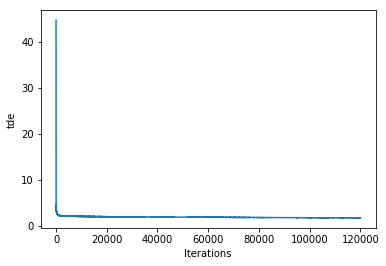

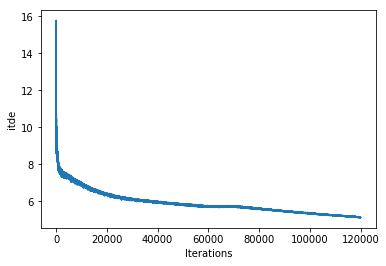

120000 200000 3.181158 0.418550 1.043068 1.719540 5.122758
121000 200000 3.193935 0.420493 1.057109 1.716333 5.115901
122000 200000 3.172942 0.417671 1.040226 1.715045 5.100655
123000 200000 3.180246 0.419240 1.049604 1.711402 5.109031
124000 200000 3.110684 0.420502 0.980666 1.709516 5.096955
125000 200000 3.134551 0.420791 1.005480 1.708280 5.091327
126000 200000 3.181968 0.419509 1.055610 1.706849 5.079149
127000 200000 3.131572 0.419252 1.009666 1.702654 5.072164
128000 200000 3.131820 0.421287 1.010310 1.700224 5.060253
129000 200000 3.134674 0.421090 1.012832 1.700752 5.046355


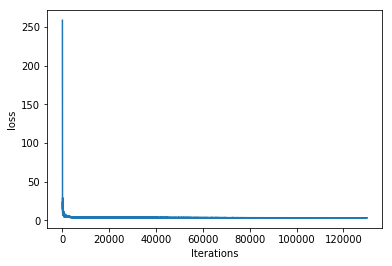

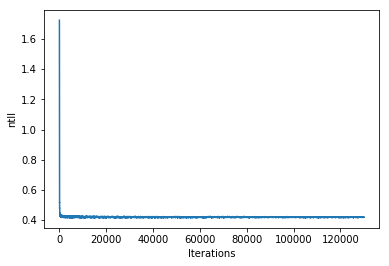

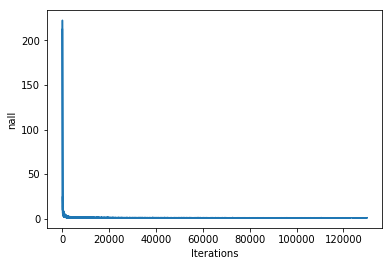

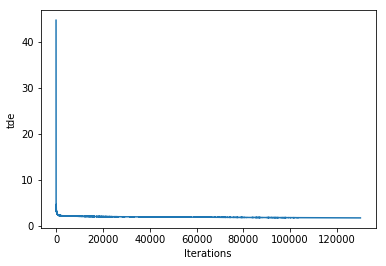

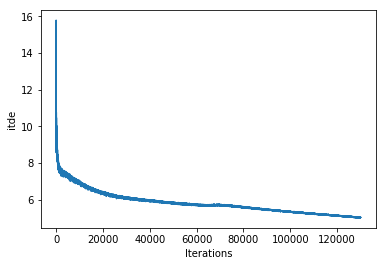

130000 200000 3.231050 0.419502 1.114861 1.696686 5.042937
131000 200000 3.166909 0.421279 1.049824 1.695807 5.028908
132000 200000 3.193388 0.419430 1.081046 1.692912 5.023684
133000 200000 3.117147 0.417864 1.006465 1.692818 5.003538
134000 200000 3.117086 0.419461 1.006437 1.691189 5.004726


KeyboardInterrupt: 

In [51]:
val_log = None
while len(full_train_logs['loss_evals']) < n_training_iters:
    demo_batch = sample_batch(nn_rollouts, train_idxes, batch_size)
    t = len(full_train_logs['loss_evals'])
    train_log = compute_batch_loss(demo_batch, constraints, step=True, adt=True, trans=False, t=t)
    if val_log is None or len(full_train_logs['loss_evals']) % val_update_freq == 0:
        val_log = compute_batch_loss(val_demo_batch, constraints, step=False, adt=True, trans=False, t=t)

    if len(full_train_logs['loss_evals']) % 1000 == 0:
#         print(t, val_log['loss'])
          print('%d %d %f %f %f %f %f' % (
            t, n_training_iters, val_log['loss'], val_log['ntll'], val_log['nall'], val_log['tde'], val_log['itde']))
    for k, v in train_log.items():
        full_train_logs['%s_evals' % k].append(v)
    for k, v in val_log.items():
        full_train_logs['val_%s_evals' % k].append(v)
    if len(full_train_logs['loss_evals']) % 10000 == 0:
        for k in ['val_loss_evals','val_ntll_evals','val_nall_evals','val_tde_evals', 'val_itde_evals']:
            plt.xlabel('Iterations')
            plt.ylabel(k.split('_')[1])
            plt.plot(full_train_logs[k])
            plt.show()

In [ ]:
# for k in ['val_loss_evals','val_ntll_evals','val_nall_evals','val_tde_evals']:
#     plt.xlabel('Iterations')
#     plt.ylabel(k.split('_')[1])
#     plt.plot(full_train_logs[k])
#     plt.show()

In [52]:
tts = np.arange(3)
acts = np.arange(mdp.nA) 
adt_samples = np.transpose([np.tile(tts, len(acts)), np.repeat(acts, len(tts))])
adt_samples = adt_samples[adt_samples[:,1].argsort()]

In [53]:
adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]

In [54]:
adt_samples

array([[0, 0],
       [1, 0],
       [2, 0],
       [0, 1],
       [1, 1],
       [2, 1],
       [1, 2],
       [2, 2],
       [0, 2],
       [0, 3],
       [1, 3],
       [2, 3],
       [0, 4],
       [1, 4],
       [2, 4],
       [1, 5],
       [0, 5],
       [2, 5]])

In [55]:
softmax(adt_probs)

array([[0.7645556 , 0.09553625, 0.00006505, 0.13983366, 0.00000424,
        0.00000509],
       [0.5919411 , 0.13027114, 0.00039934, 0.21255845, 0.00008037,
        0.06474966],
       [0.0000027 , 0.00000165, 0.        , 0.00000086, 0.        ,
        0.99999475],
       [0.08389581, 0.8140015 , 0.10204773, 0.00004703, 0.00000355,
        0.00000429],
       [0.11373388, 0.62002957, 0.2284076 , 0.0001916 , 0.00013018,
        0.03750718],
       [0.00000072, 0.00000278, 0.00000159, 0.        , 0.        ,
        0.9999949 ],
       [0.00011046, 0.06224868, 0.8352095 , 0.08085968, 0.00003493,
        0.02153667],
       [0.        , 0.00000112, 0.00000413, 0.00000022, 0.        ,
        0.9999945 ],
       [0.00004762, 0.06838349, 0.83629763, 0.09526389, 0.00000308,
        0.00000428],
       [0.11856817, 0.00003921, 0.0761532 , 0.80523074, 0.00000434,
        0.00000434],
       [0.09235412, 0.0002463 , 0.1574708 , 0.7240671 , 0.00013856,
        0.02572318],
       [0.00000188, 0

In [56]:
states = featurize_states(np.arange(mdp.nS))
q_vals = sess.run([demo_q_t], feed_dict={demo_obs_t_feats_ph:states})[0]

In [ ]:
demo_batch

In [ ]:
dem = [demo_q_t, act_log_likelihoods]
dqt, actll = sess.run(dem, feed_dict={demo_obs_t_feats_ph: demo_batch[1],
                                    demo_act_t_ph: demo_batch[2],
                                    demo_next_obs_t_feats_ph: demo_batch[4],
                                    demo_dir_t_ph: demo_batch[5],
                                    demo_tile_t_ph: demo_batch[6],
                                    demo_batch_size_ph: demo_batch[0].shape[0]})

In [ ]:
i = actll.argmin()
print(list(map(lambda x: x[i], demo_batch)))

In [ ]:
actll

In [ ]:
evals = [constraint_q_ts, constraint_adt_pred_probs, constraint_adt_pred_dir, adt_target_t, ca_indexes, cqtp1_misshaped, constraint_q_tp1, constraint_v_tp1, constraint_sprimes_reshaped, adt_V]
c_qs, pred_probs, pred_dirs, adt_targs, acties, cq1, cq2, cv, cspr, av  = sess.run(evals,
                        feed_dict={constraint_obs_t_feats_ph: constraints[0],
                                    constraint_act_t_ph: constraints[1],
                                    constraint_rew_t_ph: constraints[2],
                                    constraint_next_obs_t_feats_ph: constraints[3],
                                    constraint_tile_t_ph: constraints[4],
                                    constraint_batch_size_ph: constraints[0].shape[0]})

In [ ]:
constraints[0][t_ind], constraints[1][t_ind], constraints[2][t_ind], constraints[4][t_ind], c_qs[t_ind], adt_targs[t_ind], pred_probs[t_ind], cv[t_ind], cq2[t_ind], constraints[3][t_ind], av[t_ind] #82, 153

In [ ]:
constraints[0][t_ind], constraints[1][t_ind], constraints[2][t_ind], constraints[4][t_ind], c_qs[t_ind], adt_targs[t_ind], pred_probs[t_ind], cv[t_ind], cq2[t_ind], constraints[3][t_ind], av[t_ind] #82, 153

In [ ]:
np.where(cq2 > 50)

In [ ]:
np.where((constraints[0] == np.array([8,7])).all(axis=1))

In [ ]:
t_ind = 436

In [ ]:
cspr#[163*5+4]

In [ ]:
constraints[3]

In [ ]:
constraints[3].transpose((0,2,1)).reshape(405*5,2)

In [ ]:
pred_probs[t_ind].dot(cv[t_ind])

In [ ]:
logsumexp(q_vals, axis=1)

In [ ]:
q_vals

In [ ]:
# # q_vals[:,0] = -np.inf
# q_vals[:,1] = -np.inf
# q_vals[:,2] = -np.inf
# q_vals[:,3] = -np.inf
# q_vals[:,4] = -np.inf

In [ ]:
plot_values(mdp, q_vals)

In [ ]:
softmax(adt_probs.reshape((5,5,2)))

## IDL Only

In [ ]:
idl_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [ ]:
maxiter = 300
learning_rate = 1

In [ ]:
Ti_thetas = T_estimate(adt_obs[train_demo_example_idxes])
Qi, Ri = None, mdp.rewards

In [ ]:
while len(idl_train_logs['tt_lls']) < maxiter:
    batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
    #Should we initialize Qs or nah?
    tp_ll, dT_pol, Qi = eval_T_pol_likelihood_and_grad(Ti_thetas, Ri, batch_demo_sas, Q_inits=Qi)
    tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ti_thetas, batch_demo_adt)
    train_likelihood = tp_ll + tt_ll
    vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ti_thetas, Qi)
    val_likelihood = vp_ll + vt_ll
    ttd = true_trans_loss(softmax(Ti_thetas))
    Ti_thetas += learning_rate * (dT_trans + dT_pol)
    
    print('%d %f %f %f %f' % (len(idl_train_logs['tt_lls']), vp_ll, vt_ll, vp_ll + vt_ll, ttd))
    idl_train_logs['train_likelihoods'].append(train_likelihood)
    idl_train_logs['val_likelihoods'].append(val_likelihood)
    idl_train_logs['tp_lls'].append(tp_ll)
    idl_train_logs['tt_lls'].append(tt_ll)
    idl_train_logs['vp_lls'].append(vp_ll)
    idl_train_logs['vt_lls'].append(vt_ll)
    idl_train_logs['true_trans_loss'].append(ttd)

In [ ]:
plt.plot(idl_train_logs['vp_lls'])

In [ ]:
plt.plot(idl_train_logs['vt_lls'])

In [ ]:
plt.plot(idl_train_logs['val_likelihoods'])

In [ ]:
print(Qi[[s for s in range(nS) if mdp.get_tile_type(s)==1]])

In [ ]:
plot_mars(mdp,tabsoftq_gen_pol(Qi))
print(softmax(Ti_thetas))

In [ ]:
tabsoftq_gen_pol_probs(Qi)[:,4]

In [ ]:
print(softmax(Ti_thetas)) # - softmax(T_estimate(adt_obs[train_demo_example_idxes])))

In [ ]:
test_T_likelihood(softmax(Ti_thetas), val_sas_obs, val_adt_obs)

In [ ]:
test_T_likelihood(softmax(T_estimate(adt_obs[train_demo_example_idxes])), val_sas_obs, val_adt_obs)

In [ ]:
test_T_likelihood(true_tps, val_sas_obs, val_adt_obs)

In [ ]:
true_trans_loss(softmax(Ti_thetas))

In [ ]:
softmax(Ti_thetas)

In [ ]:
true_trans_loss(softmax(T_estimate(adt_obs[train_demo_example_idxes])))

In [ ]:
softmax(T_estimate(adt_obs[train_demo_example_idxes]))

In [ ]:
plot_values(mdp, Qi)

In [ ]:
plot_values(mdp, exQs)

## SERD only

In [ ]:
serd_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [ ]:
Ts_thetas = T_estimate(adt_obs[train_demo_example_idxes]) #np.log(Tps2+.000000001)
feats = mdp.feature_map
Rs_thetas = np.random.normal(loc=1,scale=0.1,size=feats.shape[1])
Qs = None

In [ ]:
maxiter = 300
t_learning_rate = lambda t: 0 if t<20 else 3 - (2 * int(t/(maxiter/2)))
r_learning_rate = lambda t: 2e-1 if t<20 else 1e-1

In [ ]:
while len(serd_train_logs['tt_lls']) < maxiter:
    prevQs = Qs.copy() if Qs is not None else None
    t = len(serd_train_logs['tt_lls'])
    batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
    Rs = feats.dot(Rs_thetas)
    tp_ll, dT_pol, dR_pol, Qs = eval_TR_pol_likelihood_and_grad(Ts_thetas, Rs, feats, batch_demo_sas, Q_inits=Qs)
    tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ts_thetas, batch_demo_adt)
    train_likelihood = tp_ll + tt_ll
    vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ts_thetas, Qs)
    val_likelihood = vp_ll + vt_ll
    ttd = true_trans_loss(softmax(Ts_thetas))
    Rs_thetas += r_learning_rate(t) * dR_pol
    Ts_thetas += t_learning_rate(t) * (dT_trans + dT_pol)

#     print(dT_trans)
#     print(dT_pol)
#     print(softmax(Ts_thetas))
#     print(dR_pol * r_learning_rate(t))
#     print(Rs_thetas)
#     if prevQs is not None:
#         print("Q_diff")
#         print(np.linalg.norm(Qs-prevQs))

    
    print('%d %f %f %f %f' % (t, vp_ll, vt_ll, vp_ll + vt_ll, ttd))
    serd_train_logs['train_likelihoods'].append(train_likelihood)
    serd_train_logs['val_likelihoods'].append(val_likelihood)
    serd_train_logs['tp_lls'].append(tp_ll)
    serd_train_logs['tt_lls'].append(tt_ll)
    serd_train_logs['vp_lls'].append(vp_ll)
    serd_train_logs['vt_lls'].append(vt_ll)
    serd_train_logs['true_trans_loss'].append(ttd)

In [ ]:
print(softmax(Ts_thetas))

In [ ]:
print(Rs_thetas)

In [ ]:
true_trans_loss(softmax(Ts_thetas))

In [ ]:
plt.plot(serd_train_logs['vp_lls'][:250])
plt.plot(idl_train_logs['vp_lls'][:250])

In [ ]:
plt.plot(serd_train_logs['vt_lls'][:250])
plt.plot(idl_train_logs['vt_lls'][:250])

In [ ]:
plt.plot(serd_train_logs['val_likelihoods'], label = "SERD")
plt.plot(idl_train_logs['val_likelihoods'], label = "IDL")
plt.title("Log likelihood of Demonstrations")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Log Likelihood")
plt.legend()

In [ ]:
plt.plot(serd_train_logs['true_trans_loss'], label = "SERD")
plt.plot(idl_train_logs['true_trans_loss'], label = "IDL")
plt.title("Square Error of Learned Transition Parameters")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Summed Square Error")
plt.legend()

## Comparison Tests

In [ ]:
def demo_stats(mdp, demos):
    demo_rewards = []
    for i in range(len(demos)):
        demo_rewards += [np.array([mdp.rewards[obs[0][2]] for obs in demos[i]])]
#         for j in range(len(demo_rewards[i])):
#             print(demos[i][j][0], demo_rewards[i][j])
    
    discounted_demo_rewards = [np.power(gamma,np.arange(len(dr)))*dr for dr in demo_rewards]
    demo_rewards, discounted_demo_rewards = np.array(demo_rewards), np.array(discounted_demo_rewards)
    data = {"mean episode reward": np.mean(np.sum(demo_rewards, axis=1)),
            "sd episode reward": np.std(np.sum(demo_rewards, axis=1)),
            "mean discounted episode reward": np.mean(np.sum(discounted_demo_rewards, axis=1)),
            "sd discounted episode reward": np.std(np.sum(discounted_demo_rewards, axis=1))}
    return data
    
    

In [ ]:
SERD_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qs), 2000, demo_time_steps)
IDL_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qi), 2000, demo_time_steps)

In [ ]:
print(demo_stats(mdp, SERD_demos))

In [ ]:
print(demo_stats(mdp, IDL_demos))

In [ ]:
plot_values(mdp, Qs)

In [ ]:
plot_values(mdp, Qi)

In [ ]:
print(reward_map[5][0], Qi[2], Q[2])

### Transfer

In [ ]:
tile_map2 = [
        "2FFFFFFF1",
        "FFFFFFFFF",
        "FFFFUFFFF",
        "FFFUUUFSF",
        "FFUU3UUFF",
        "FSFUUUFSF",
        "FSFFUFFSF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]
reward_map2, texture_map2 = build_reward_map(tile_map2, tile_rewards, goal_tile_rewards, tile_reward_modifier)
# reward_normalizer2 = (1-gamma)/(np.max(reward_map2))
# reward_map2 *= reward_normalizer2
# time_penalty *= reward_normalizer2
# temperature2 = 1/(reward_normalizer2)
# print(temperature2)
print(reward_map2)
print(texture_map2)

In [ ]:
mdp = MarsExplorerEnv(tile_map2, reward_map2, texture_map2, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

In [ ]:

Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tsps = softmax(Ts_thetas,axis=1)
Ts = mdp.adt_trans_to_sas_trans(Tips)
Rs = mdp.feature_map.dot(Rs_thetas)
Qst = tabsoftq_iter(Rs, Ts, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
IDL_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qit), 1000, demo_time_steps)
SERD_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qst), 1000, demo_time_steps)

In [ ]:
plot_mars(mdp,tabsoftq_gen_pol(Qit),Qs=Qit)

In [ ]:
print(demo_stats(mdp, IDL_trans_demos))

In [ ]:
print(demo_stats(mdp, SERD_trans_demos))

In [ ]:
plot_values(mdp, Qit)

In [ ]:
plot_values(mdp, Qst)

In [ ]:
Qtrue = tabsoftq_learn_Qs(mdp)
plot_values(mdp,Qtrue)

In [ ]:
mdp.get_possible_sprimes(np.array([[0,0],[0,1]]))

In [ ]:
i = 15
mdp.get_direction_moved(nn_rollouts[0][i][0],nn_rollouts[0][i+1][0])

In [ ]:
nn_rollouts[0][i], nn_rollouts[0][i+1]

In [ ]:
nn_rollouts[0][:30]